In [1]:
#Imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [2]:
#Read in all the words
words = open('../data/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
#Size of our dataset
len(words)

32033

In [4]:
#Build stoi and itos lookup tables
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# Build train, dev, and test datasets
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [121]:
#Initialize network parameters

g = torch.Generator().manual_seed(6789998212) #for reproducability

#Architectural hyperparameters
n_embed = 10
n_hidden = 200

#Model parameters
C = torch.randn((vocab_size,n_embed),generator=g)
W1 = torch.randn((n_embed*block_size,n_hidden),generator=g) * (5/3)/((n_embed * block_size)** 0.5)
b1 = torch.randn(n_hidden,generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),generator=g) * (5/3)/((n_hidden * vocab_size)** 0.5)
b2 = torch.randn(vocab_size,generator=g) * 0 #No offset to begin with

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [122]:
#Train on the training split

#Training Hyperparameters
# learning_rate (set dynamically below)
max_steps = 200000
batch_size = 32

lossi=[]

for i in range(max_steps):

    #generate minibatch indices
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    #forward pass
    embeds = C[Xtr[ix]]
    embcat = embeds.view(embeds.shape[0],-1)
    hid_pre = embcat @ W1 + b1
    hidden = torch.tanh(hid_pre)
    logits = hidden @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) #loss *for* the minibatch

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    learning_rate = 0.1 if i < 100000 else 0.01 #Factor of 10 learning rate decay
    for p in parameters:
        p.data += -learning_rate * p.grad

    #track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break

      0/ 200000: 3.2291
  10000/ 200000: 2.2474
  20000/ 200000: 1.7790
  30000/ 200000: 2.2440
  40000/ 200000: 2.1819
  50000/ 200000: 2.1097
  60000/ 200000: 2.3273
  70000/ 200000: 1.6716
  80000/ 200000: 1.8856
  90000/ 200000: 2.1486
 100000/ 200000: 2.2203
 110000/ 200000: 1.5879
 120000/ 200000: 2.0658
 130000/ 200000: 2.2314
 140000/ 200000: 2.2218
 150000/ 200000: 2.2916
 160000/ 200000: 1.8022
 170000/ 200000: 1.5866
 180000/ 200000: 1.9366
 190000/ 200000: 2.1854


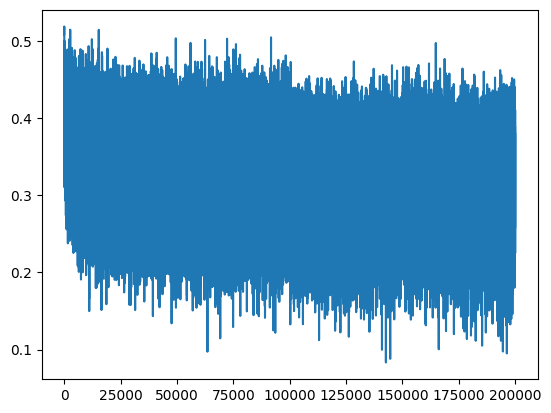

In [123]:
#Plot training progress
plt.plot(lossi)

In [124]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss. item())

split_loss('train')
split_loss('val')

train 2.039095401763916
val 2.1040632724761963


In [125]:
g = torch.Generator().manual_seed(6789998212)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        embeds = C[torch.tensor(context)]
        hidden = torch.tanh(embeds.view(1,-1) @ W1 + b1)
        logits = hidden @ W2 + b2
        probs = F.softmax(logits,dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and append the sample
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the specail '.' token, stop
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))
        

elander.
tifo.
ivayda.
khalya.
hun.
kochubliyah.
sose.
ga.
brunai.
ston.
haleigh.
rodin.
breona.
dedyn.
jelie.
trace.
frydon.
raz.
tziella.
evon.


### Problem 1 - Inital loss is much worse than random guessing

Our inital loss was recorded to be 17, which is significantly worse than random guessing (3.2958). 

How are we worse than random? Well, in initializing parameters *randomly* rather than *uniformly*, the initialized network has random preferances that are worse than uniform ignorance.

Intuitively, it's sometimes easier to build off an empty lot than to tear down an existing building.

In [79]:
#Random guessing
-torch.tensor(1/27.0).log()

tensor(3.2958)

We solve this by making the `logits = h @ W2 + b2` close to but not exactly zero by initializing b2 to be 0 and multipling W2 by 0.01.

### Problem 2 - Tanh is saturated

The derivative of tanh `(_/‾)` is zero when tanh = +/-1. When the gradient disappears and no information can be backpropegated any further

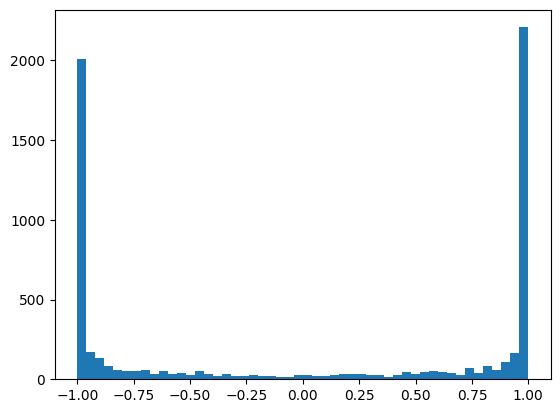

In [ ]:
#Most tanh values are in the tails
#(This is produced by breaking after 1 training iteration)
plt.hist(hidden.view(-1).tolist(),50);

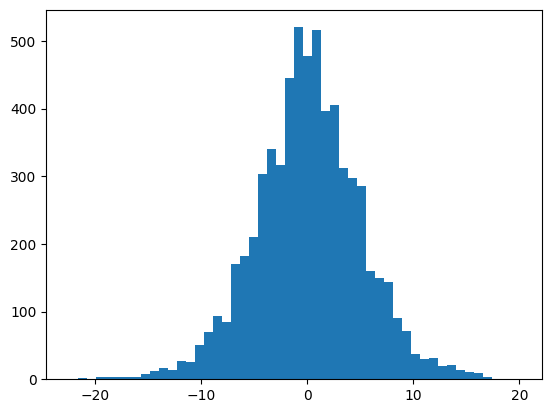

In [ ]:
#...Because most values passed in are large!
#(This is produced by breaking after 1 training iteration)
plt.hist(hid_pre.view(-1).tolist(), 50);

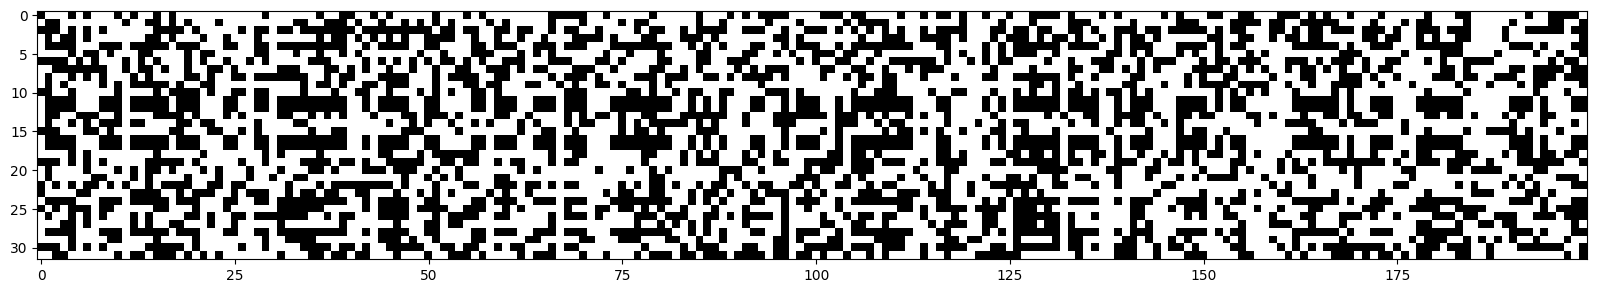

In [95]:
#(32,200) is (batch_size,n_hidden)
plt.figure(figsize=(20,10))
plt.imshow(hidden.abs() > 0.99, cmap='gray', interpolation='nearest')

If we had an entire of white here column here, that would indicate a dead neuron - one that didn't learn from a single example in the batch because it was always saturated.

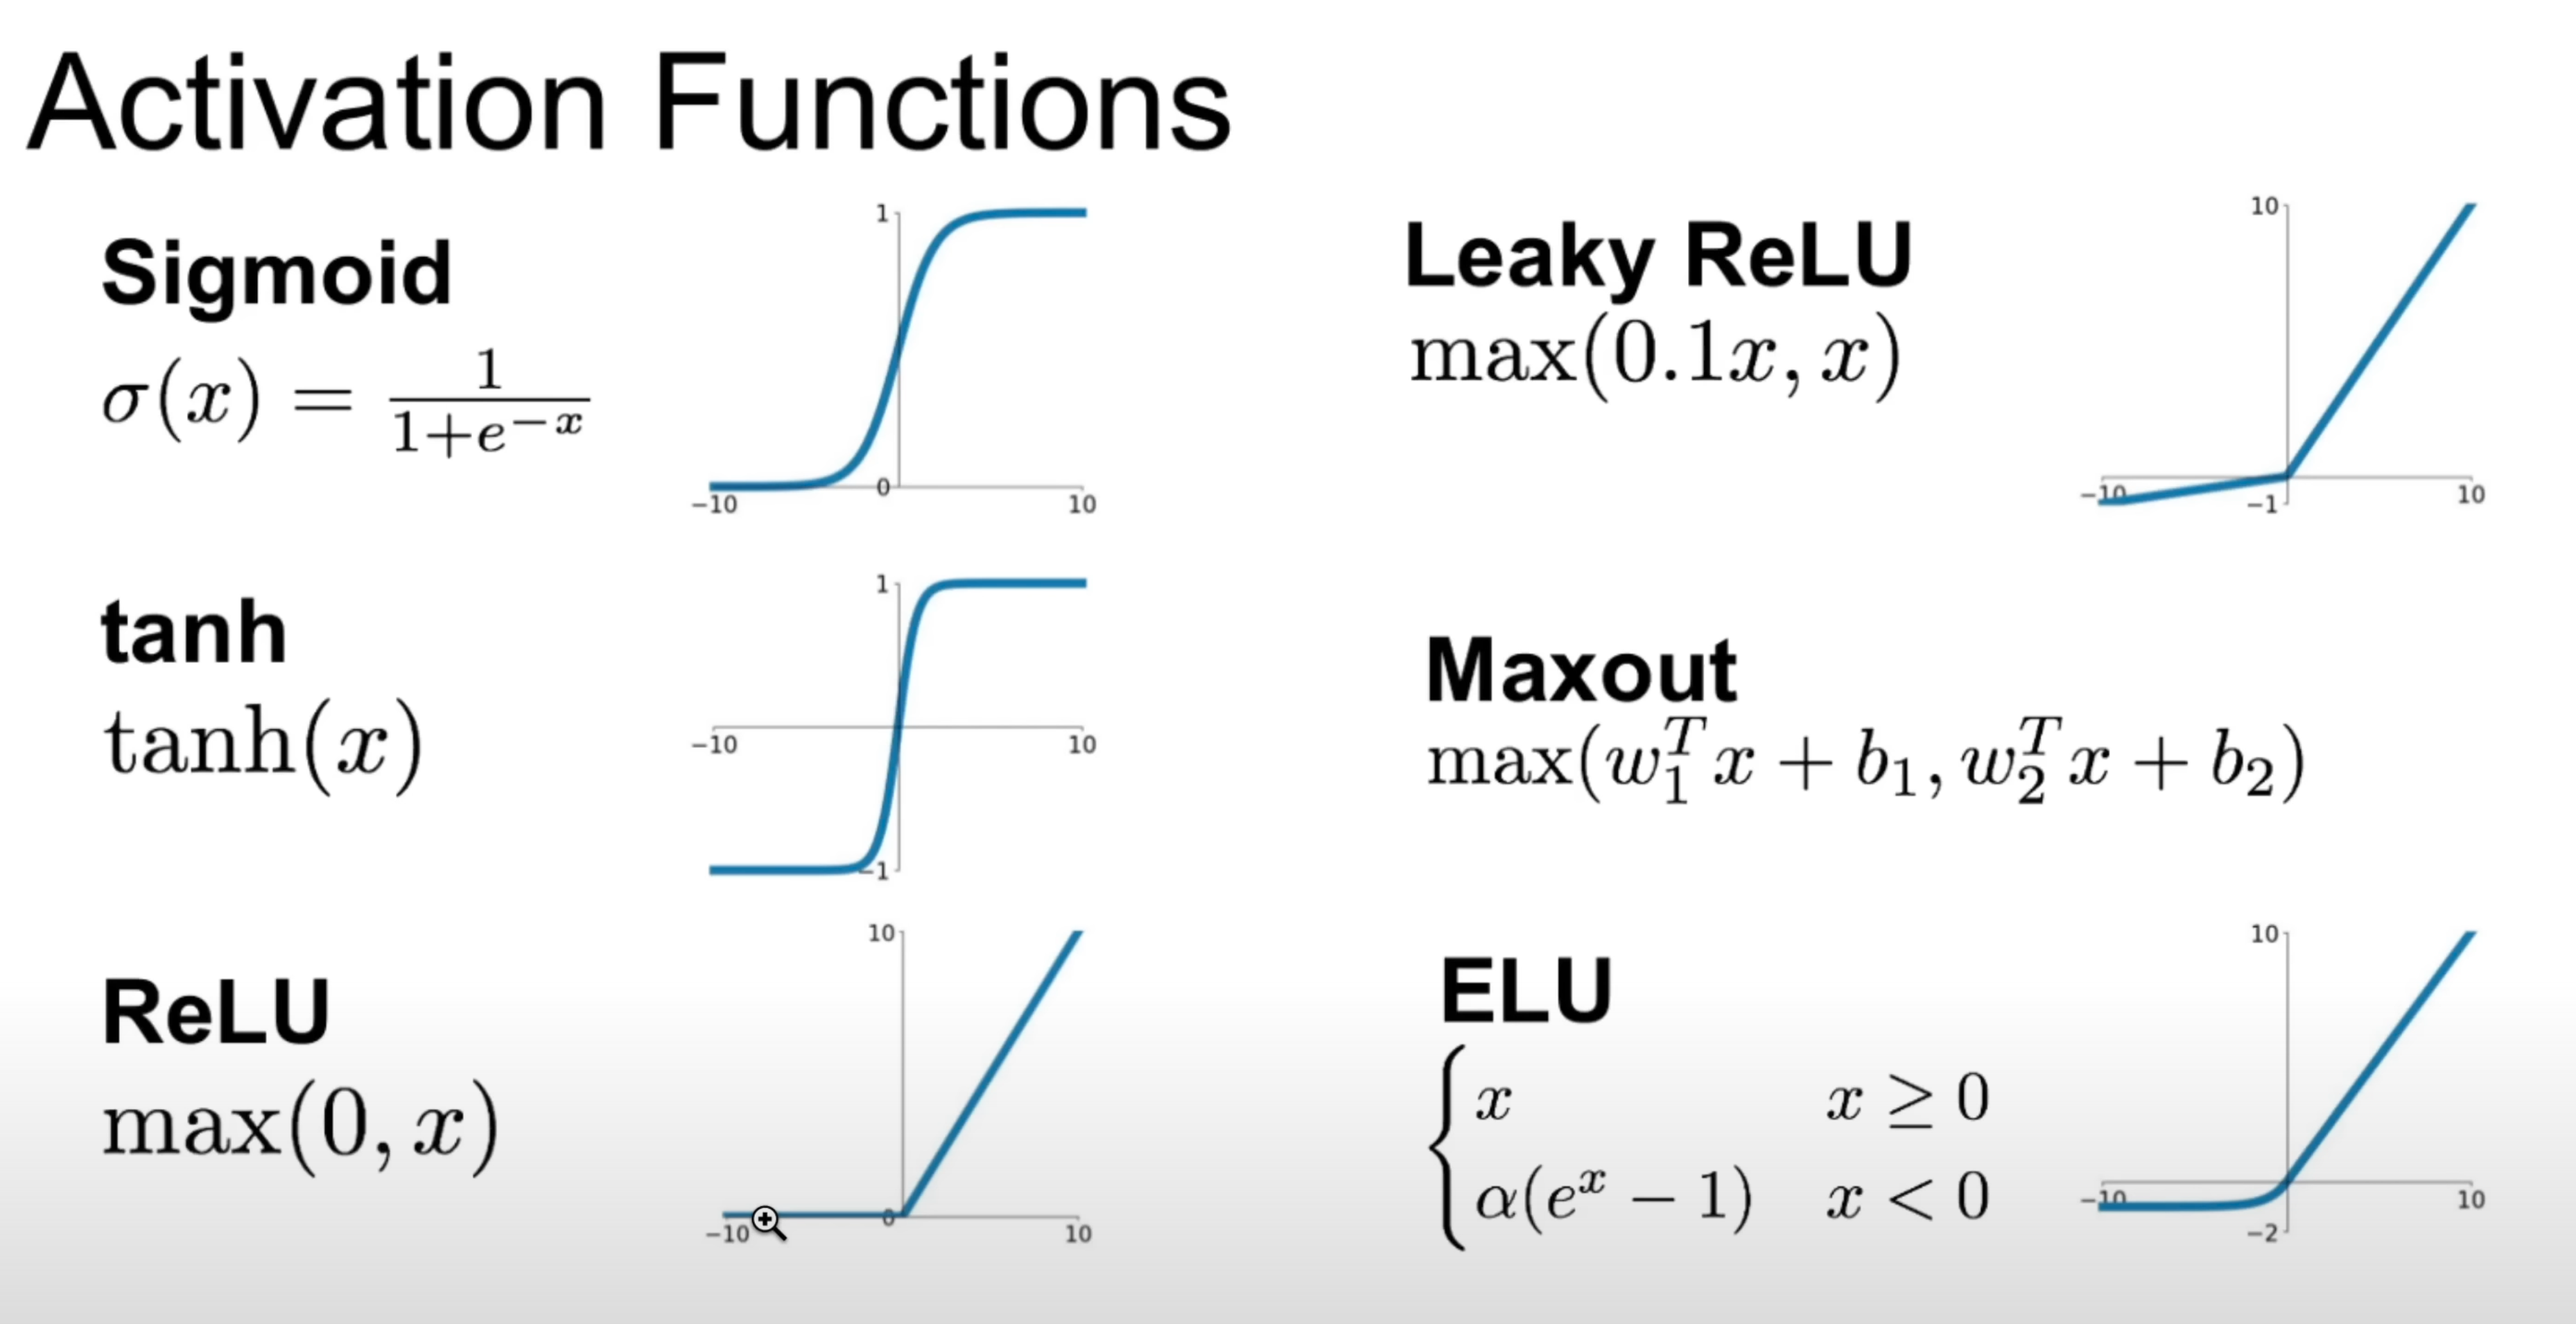

Neurons can be killed during initialization or during optimization with too high a learning rate. They get "knocked off the data manifold" and won't learn from any further example.

We fix this in the same way as the first problem. By explicitly squishing the weight and bias initializations W1 and b1.

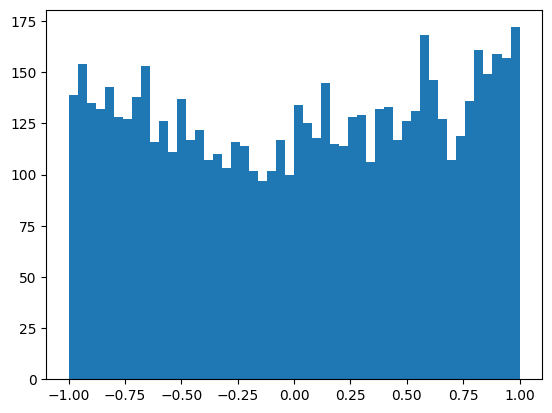

In [ ]:
#(This is produced by breaking after 1 training iteration)
plt.hist(hidden.view(-1).tolist(),50);

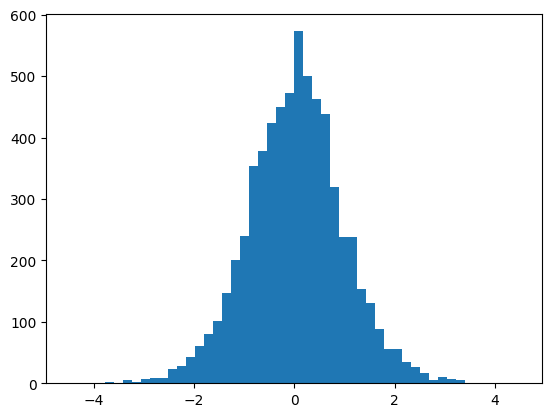

In [ ]:
#(This is produced by breaking after 1 training iteration)
plt.hist(hid_pre.view(-1).tolist(), 50);

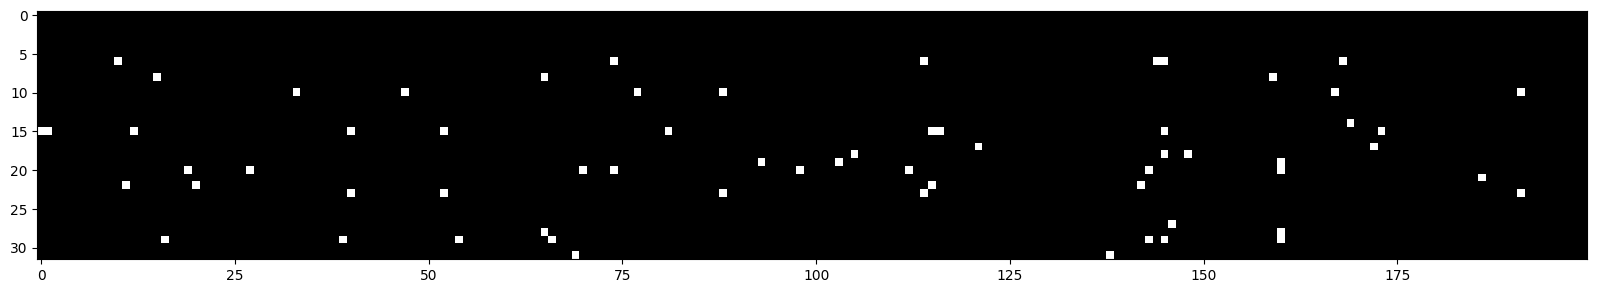

In [ ]:
#(32,200) is (batch_size,n_hidden)
#(This is produced by breaking after 1 training iteration)
plt.figure(figsize=(20,10))
plt.imshow(hidden.abs() > 0.99, cmap='gray', interpolation='nearest')

### Q - How did we set the "squish" parameters?

We basically want to keep the distribution of activations to unit standard deviation. This is something you can calculate analytically and it turns out you just divide by the square root of the input dimension (in this toy example, 10)

torch.Size([1000, 200])
tensor(-0.0232) tensor(0.9817)
tensor(0.0044) tensor(0.9697)


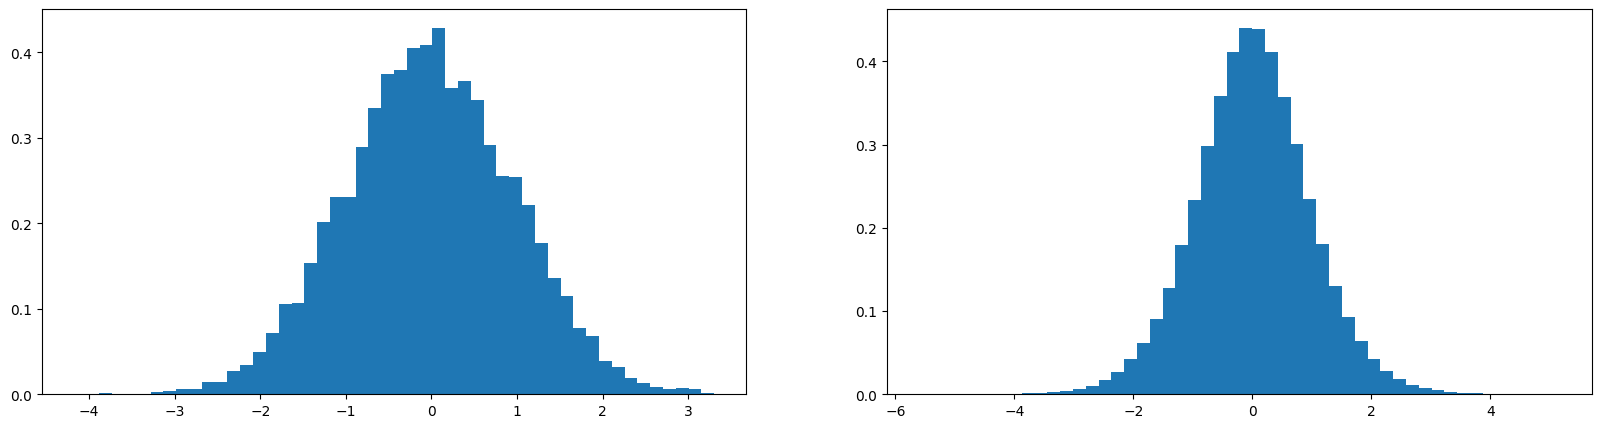

In [120]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(y.shape)
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

The question of optimally initializing neural networks has been researched extensively. The standard way to do it is described in [Kaiming et al 2015](https://arxiv.org/pdf/1502.01852) and has it's own implementation in the pytorch standard library

All of this used to be a much bigger deal. Now we have architectural + training innovations that make our training a lot more robust against poor initialization. These include residual connections, normalization layers (batch, layer, group), and better optimizers than SGD like RMSprop and ADAM.

As a result, Andrej just initializes his weights by the square root of the `fan_in` like we did here

### Batch Normalization

From a 2015 Google paper. Made it possible to train deep neural nets quite reliably. The idea is that we want the values being passed into the activation function to be neither to small nor large *at initialization*, so why not just subtract the mean and divide by the variance of each minibatch? Mean and standard deviation are both differentiable operators so it's perfectly legal.

This makes the input well-behaved but takes away the scale + position degrees of freedom so we add them back in on the other side of the activation function as gain and offset parameters that the network can learn.

It's customary to append a such batch normalization layer after any linear layer or convolutional layer to make the distribution being fed into the following nonlineaer activation function have zero mean and unit norm.

Batch normalization comes at a "terrible cost" - it couples the training examples through the batch statistics. The activations of an example aren't only due to that example, they're also due to the other randomly selected examples in the minibatch which came along for a ride. Strangely enough, this stochastic noise is good. Like a regularizer, it makes it harder for the neural net to overfit specific examples.

But the mathematical coupling is ugly and buggy and people have introduced layer normalization, instance normalization, group normalization to normalize without the coupling. But batch normalization and it's regularizing effect work quite well so people have a hard time justifying the switch to these. 

Another issue that arises is how you then feed in a single example to such a trained network? It expects batches of some (hopefully optimal yet otherwise arbitrary size), not single examples. To fix this we keep running averages of the means and stds from each batch and use those values for the trained model at inference time.

In [ ]:
#Initialize network parameters (with batch normalizaiton)

g = torch.Generator().manual_seed(6789998212) #for reproducability

#Architectural hyperparameters
n_embed = 10
n_hidden = 200

#Model parameters
C = torch.randn((vocab_size,n_embed),generator=g)
W1 = torch.randn((n_embed*block_size,n_hidden),generator=g) * (5/3)/((n_embed * block_size)** 0.5)
# b1 = torch.randn(n_hidden,generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),generator=g) * (5/3)/((n_hidden * vocab_size)** 0.5)
b2 = torch.randn(vocab_size,generator=g) * 0 #No offset to begin with
bn_gain = torch.ones((1,n_hidden))
bn_bias = torch.zeros((1, n_hidden))
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1,n_hidden))

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [ ]:
#Train on the training split (with batch normalization)

#Training Hyperparameters
# learning_rate (set dynamically below)
max_steps = 200000
batch_size = 32

lossi=[]

for i in range(max_steps):

    #Generate minibatch indices
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    #Forward pass
    embeds = C[Xb]
    embcat = embeds.view(embeds.shape[0],-1) #concatenate the blocks' embeddings
    #Linear layer
    hid_preact = embcat @ W1 #+ b1 -> affine shift not needed due to batch normalization
    #Batch normalizaiton layer
    bn_mean_i = hid_preact.mean(0, keepdim=True)
    bn_std_i = hid_preact.std(0, keepdim=True)
    hid_preact = bn_gain * (hid_preact - bn_mean_i) / bn_std_i  + bn_bias
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i
    #Nonlinearity
    hidden = torch.tanh(hid_preact) #Hidden layer
    logits = hidden @ W2 + b2 #Output layer
    loss = F.cross_entropy(logits, Yb) #minibatch loss

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #Update
    learning_rate = 0.1 if i < 100000 else 0.01 #Factor of 10 learning rate decay
    for p in parameters:
        p.data += -learning_rate * p.grad

    #Track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3253
  10000/ 200000: 2.1521
  20000/ 200000: 2.0826
  30000/ 200000: 2.2606
  40000/ 200000: 1.8722
  50000/ 200000: 1.9160
  60000/ 200000: 1.8939
  70000/ 200000: 2.5499
  80000/ 200000: 2.5382
  90000/ 200000: 2.2141
 100000/ 200000: 2.0621
 110000/ 200000: 2.1172
 120000/ 200000: 2.1965
 130000/ 200000: 1.7663
 140000/ 200000: 2.3374
 150000/ 200000: 1.6914
 160000/ 200000: 2.2507
 170000/ 200000: 1.8316
 180000/ 200000: 1.9292
 190000/ 200000: 2.1597


In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hid_preact = embcat @ W1 #+ b1
    hid_preact = bn_gain * (hid_preact - bn_mean_running) / bn_std_running + bn_bias
    hidden = torch.tanh(hid_preact)
    logits = hidden @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss. item())

split_loss('train')
split_loss('val')

train 2.0685033798217773
val 2.1100902557373047


The point of batch normalization is to center and scale the data being passed into the activation function. Soooo that bias term we had lurking around is useless. Instead, bias (affine shift) will be added on the other side of the activation in the form of bn_bias. Weights are still important because linear transformations do much more than isotropic scaling.